## Recommender Systems for Digital Media in online education

***
### Background <br/>

**Purpose**

The "e-learning" website can provide people with rich and high-quality online learning courses, making it possible to transform education into lifelong learning. It has the advantages of low cost, courses can be taken multiple times, and flexible arrangement of learning plans according to the user's own comfort and needs, so it is gradually being widely used. Additionally, traditional offline education has been subject to various restrictions due to the COVID-19 pandemic. E-learning is becoming more and more necessary and very important in education. If an "e-learning" website site wants to build a good brand image to attract more people to visit their website and make money by helping users customize a personalized   learning plan, it needs to understand their registered users deeply, and build a good recommender system to increase user's loyalty and engagement.

**Feature**

The log files include actions taken by registered users on different courses when they visit the "e-learning" website. Therefore, our group project leverages implicit feedback from registered users, applying the user-based and item-based collaborative filtering algorithms to recommend courses to users that may fit their preference by similar users and items.

**User Behaviour - Implicit Feedback**

There are five types of implicit feedbacks including (1) view course, (2) rundown, (3) detailed description, (4) institution and (5) teacher profile.
Different behaviors of users are driven by the user's own level of interest, and implicitly represent different meanings. When users visit the website, they must first click (1) view course to enter the course display page provided by the website, and then they can proceed to the next step according to their own needs; By clicking on (2) Outline, users can get a general understanding of the brief teaching plan of the course they are interested in; By browsing (3) detailed description, users have a more comprehensive and detailed understanding of the course, which has important reference value for themselves to decide whether this course meets their needs; In addition, (4) colleges and (5) teacher profiles are key indicators to reflect the quality of course teaching, so when users view these two kinds of information, it means that the user has great interest in the course, which is in line with the user's needs and preferences. Therefore, checking the institution and teacher profile has the highest weight, the second highest weight is detailed description, when users are interested in a course, the detailed description of the course can provide them with the information they care about, and the third highest weight is rundown, which It is the most basic exploration of the course, and the last is to view the course, because this step is the basic step for the user to generate other behaviors, and thus has no weight. The behavior flow assumption are (5) and (4), followed by (3)/(2)/(1).

The weighting are:
* view course: 0
* rundown: 15
* detailed description: 50
* institution: 80
* teacher profile: 80



In [1]:
import pandas as pd 
import numpy as np
import datetime
from datetime import date, timedelta, datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## 1.  Data Exploration and Analysis
### 1.1 Basic Information

In [2]:
# load data 
elearning = pd.read_csv('../data/' + 'elearning_dataset2.csv')

In [3]:
# checkin the type and take a glance at the head 
print(type(elearning))
elearning.head(10)

<class 'pandas.core.frame.DataFrame'>


,Date,UserID,CourseID,Event
0,2022-01-10 10:46:08,235,85,view_course
1,2022-01-10 10:48:07,235,85,rundown
2,2022-01-10 11:58:34,1223,59,view_course
3,2022-01-10 12:01:30,1223,59,detailed_description
4,2022-01-10 12:03:57,1223,59,institution
5,2022-01-10 13:03:03,189,3,view_course
6,2022-01-10 13:05:51,189,3,detailed_description
7,2022-01-10 14:11:33,104,362,view_course
8,2022-01-10 14:12:30,104,362,detailed_description
9,2022-01-10 14:15:02,104,362,teacher_profile


In [4]:
# Data Frame information (null, data type, etc.)
elearning.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      4400 non-null   object
 1   UserID    4400 non-null   int64 
 2   CourseID  4400 non-null   int64 
 3   Event     4400 non-null   object
dtypes: int64(2), object(2)
memory usage: 137.6+ KB


In [5]:
# The column labels of the DataFrame
elearning.columns

Index(['Date', 'UserID', 'CourseID', 'Event'], dtype='object')

In [6]:
# Check the index
elearning.index

RangeIndex(start=0, stop=4400, step=1)

In [7]:
# Generate descriptive statistics
elearning.describe()

,UserID,CourseID
count,4400.000000,4400.000000
mean,810.926591,195.605455
std,454.219751,115.994898
min,1.000000,1.000000
25%,422.750000,94.000000
50%,823.000000,192.000000
75%,1195.250000,296.000000
max,1599.000000,399.000000


### 1.2 Data Visualization

In [8]:
elearn_event = elearning.groupby(['Event']).count()
elearn_event

,Date,UserID,CourseID
Event,,,
detailed_description,584,584,584
institution,486,486,486
rundown,648,648,648
teacher_profile,464,464,464
view_course,2218,2218,2218


In [9]:
elearn_sort = elearn_event['UserID'].sort_values(ascending=True)
elearn_sort

Event
teacher_profile          464
institution              486
detailed_description     584
rundown                  648
view_course             2218
Name: UserID, dtype: int64

Text(0.5, 1.0, 'Event counts in elearning system')

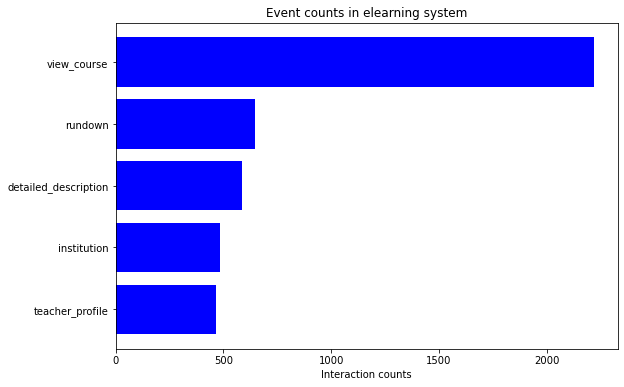

In [10]:
plt.figure(figsize=(9,6))
plt.barh(elearn_sort.index,elearn_sort.values,color='b')
plt.xlabel('Interaction counts')
plt.title('Event counts in elearning system')

## 2. User-Item Matrix

In [11]:
users = elearning.UserID.unique()
content = elearning.CourseID.unique()
print(len(users))
print(len(content))

1201
349


In [12]:
#Create a user-item binary matrix
uiMatrix = pd.DataFrame(columns=content, index=users)
uiMatrix

,85,59,3,362,100,241,392,337,380,30,...,21,278,317,139,72,367,5,231,136,64
235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Check the events type
eventTypes = elearning.Event.unique()
eventTypes

array(['view_course', 'rundown', 'detailed_description', 'institution',
       'teacher_profile'], dtype=object)

In [14]:
# Give the weighting
eventWeights = {
    'view_course': 0,
    'rundown': 15,
    'detailed_description': 50,
    'institution': 80,
    'teacher_profile': 80}

In [15]:
# Add a decay factor
def compute_decay(eventDate, decayDays):
    age = (date.today() - datetime.strptime(eventDate, '%Y-%m-%d %H:%M:%S').date()) // timedelta(days=decayDays)
    #print("Age of event:", age)
    decay = 1/age #simple decay
    #print("Decay factor:", decay)
    
    return decay

In [16]:
# Iterate the elearning dataframe
for index, row in elearning.iterrows():
    # Select the user and items involved
    currentUser = row['UserID']
    currentContent = row['CourseID']
    
    # Extract the appropriate weight for the event
    w = eventWeights[row['Event']]
    
    # Compute the decayFactor for the event
    createdEvent = row['Date']
    thresholdDays = 2 # Number of days 
    decayFactor = compute_decay(createdEvent, thresholdDays)
    
    currentValue = uiMatrix.at[currentUser, currentContent]
    if np.isnan(currentValue):
        currentValue = 0
        
    # Compute the new value and update the user-item matrix
    updatedValue = currentValue + w * decayFactor #+ (decayFactor * w)
    uiMatrix.at[currentUser, currentContent] = updatedValue
    
print(uiMatrix)

           85        59        3         362  100  241  392  337  380  30   \
235   0.333333       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1223       NaN  2.888889       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
189        NaN       NaN  1.111111       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
104        NaN       NaN       NaN  2.888889  NaN  NaN  NaN  NaN  NaN  NaN   
481        NaN       NaN       NaN       NaN  0.0  NaN  NaN  NaN  NaN  NaN   
...        ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
836        NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1380       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1521       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
414        NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1358       NaN       NaN       NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      ...  21   278  317  139  72   367  5    231  136  64   
2

In [17]:
# Normalization 
def Norm_Matrix(matrix):
    uiMatrix = matrix.astype(float)
    minValue = np.nanmin(uiMatrix.values)      # Minimum value
    maxValue = np.nanmax(uiMatrix.values)      # Maximum value

    uiMatrixNorm = uiMatrix.apply(lambda x: ((x - minValue)/(maxValue - minValue)) * 10)
    
    return uiMatrixNorm

In [18]:
# Normalize the matrix
uiMatrixNorm = Norm_Matrix(uiMatrix)
uiMatrixNorm

,85,59,3,362,100,241,392,337,380,30,...,21,278,317,139,72,367,5,231,136,64
235,0.237037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1223,NaN,2.054321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,NaN,NaN,0.790123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,2.054321,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
481,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Sparsity value 
def Sparsity(matrix):
    matrixSize = uiMatrix.shape[0]*uiMatrix.shape[1]      # Number of possible ratings
    matrixNA = uiMatrix.isna().sum().sum()                # Number of na elements
    uiMatrixSparsity = matrixNA / matrixSize              # Sparsity value

    return uiMatrixSparsity

In [20]:
# Calculate the sparsity of the matrix
Sparsity(uiMatrixNorm)

0.9947083256789352

## 3. User-based Collaborative Filtering¶

**User-based Collaborative Filtering** :

Users will pay attention to a certain course because of their own needs and interests. However, there is more than one course that meets the needs of users, and courses launched by different institutions and teachers have different appeals to users. Therefore, user-based collaborative filtering can help users find some courses based on people with similar likes and interests, so as to obtain better choices.

We resorted **Pearson Correlation Coefficient** to compute similarity between users.


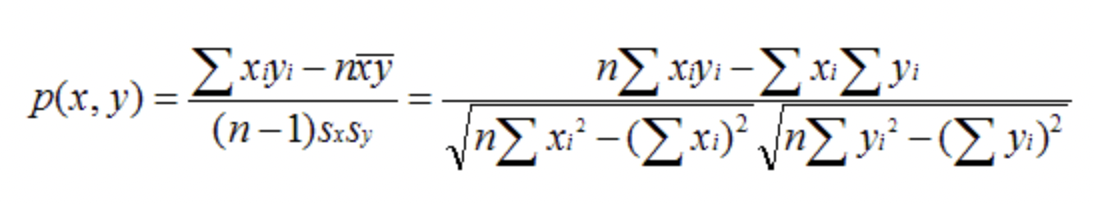

Challenge 1: **High sparsity**
The sparsity value is calculated as the number of cells without ratings divided by the total number of cells. The sparsity value of this matrix is 99.5%, which means that only a small number of users are active, resulting in a certain amount of user behavior. For users with less user behavior, the prediction results may become monotonous, and the recommendation results only have no obvious changes around a few fixed courses. In order to improve the accuracy and reference value of the prediction results of the user-based collaborative filtering algorithm, it is an effective solution to eliminate some users with less user behavior. Unfortunately, the prediction results of this method are not applicable to these users.

The implemented solution is:
By multiplying and transposing the Boolean matrix and the Boolean matrix, an overlapping user-user matrix is constructed, so that it is more intuitive to see how many co-viewed courses exist between two users. Then, we do something to eliminate users with less overlapping courses with other users. In this project, we set up at least 1 co-viewed courses between two users, which can help eliminate users with less overlapping courses with other users.

-------

Challenge 2: **Set an overlap threshold that works best for the "eLearning" dataset**
We use Pearson similarity to calculate the similarity between users, which reflects the degree of linear correlation between two variables, and its value is between [-1, 1]. And if the two users have only one overlapping item, the Pearson similarity cannot be calculated. Additionally, we've found that it's rare that more than 3 co-viewed courses between two users.

The implemented solution is: Set Up Threshold and Conditional Statement
We select user lists whose overlap value is greater than 1, and construct a new User-Item Matrix with the users who over the overlap threshold.

--------

Challenge 3: NA values and negative correlation
Because of the user-item matrix constructed from this dataset is highly sparse, there are fewer users with higher similarity. Plus generally calculated user similarity rankings will bring positive correlation values to the top of denser datasets, so negatively correlated users are meaningless.

The implemented solution is:
Users with NA value and negative value are removed in the correlation dataframe.

---------

Limitations:

1. Only a small fraction of active users can benefit from user-based collaborative filtering recommender systems.
2. Because the user item matrix is too sparse and user behavior is not rich enough, the recommendation does not have high personalization.

In [21]:
def to_bool(value):
    '''
    To a Boolean matrix
    '''
    if np.isnan(value):
        return 0
    else:
        return 1

In [22]:
def to_uiMatrixTh(uiMatrix):
    ''' 
    Eliminate the users with less overlapping courses to other users '''
    
    uiMatrixBool = uiMatrix.applymap(lambda x: to_bool(x))
    overlappingCourse = uiMatrixBool.dot(uiMatrixBool.T)       # The user-user overlapping
    usersList = overlappingCourse.columns
    
    overlapUser = []
    for user in usersList:                                    # Loop to access every user
        lookUser = overlappingCourse.loc[user]
        lookUser.to_frame()
    
        '''
        We take lists of users whose overlap value is greater than 1
        The coViewThreshold can be tune
        Because the dataframe contains the 'self'-course, the counting should be greater than 1
        '''
        coInterThreshold = 1
        if lookUser[lookUser > coInterThreshold].count() > 1:
            overlapUser.append(user)
            
    uiMatrixTh = uiMatrix.loc[overlapUser]
    uiMatrixTh = uiMatrixTh.dropna(axis = 'columns', how = 'all')

    return uiMatrixTh

In [23]:
def user_course_prediction(df, userToPredict, numUsers, numItems):
    '''
    Build the overlapping matrix to recommend courses for users who over the overlap threshold
    df : The original user-item matrix
    userToPredict : The current user
    numUsers : Number of similar users
    numItems : Number of recommended courses
    '''
    uiMatrixTh =  to_uiMatrixTh(df)                         # New User-Item Matrix with the users who over the overlap threshold
    uiMatrixTh = uiMatrixTh.astype(float)
    
    uiMatrixThIndex = list(uiMatrixTh.index)                 # Users with overlapping records
    if float(userToPredict) not in uiMatrixThIndex:         # Check if the current user has overlap record to recommend courses
        print('No recommendation for the user ' + str(userToPredict) )
        
    else:
        cuDf = uiMatrixTh.loc[userToPredict]                # Get the record of current user 
    
        corrDf = uiMatrixTh.corrwith(cuDf, axis=1, method='pearson')    # Pearson correlation between current user to every overlap user
    
        corrDf.sort_values(ascending=False, inplace=True)   
        corrDf.drop(labels=[userToPredict], inplace=True)   # Remove the current user
        corrDf = corrDf.dropna()
        corrDf = corrDf.where(corrDf > 0)                   # Remove courses with Pearson correlation =  -1
        corrDf = corrDf.head(numUsers)                      # Top K most similar users 
    
    
        # Predict courses ratings
        toPredict = cuDf[cuDf.isna()]                       # Courses that the current user has not interacted with
        ratings = uiMatrixTh.loc[corrDf.index]              # Get the ratings of the similar users
        ratingsToPredict = ratings[toPredict.index]
        predictedRatings = ratingsToPredict.mean()          # Predictive rating
        predictedRatings.sort_values(ascending=False, inplace=True)
        predictedRatings = predictedRatings.dropna()        # Remove the items without predict rating
        predictList = predictedRatings.head(numItems)       # Top K items with high predicted ratings
    
    
        # Result
        if len(predictList) == 0:
            print('No recommendation for the user ' + str(userToPredict) )
        else:
            print('For the user ' + str(userToPredict) + ', the Top ' + str(len(predictList)) + ' recommended item(s) and the prediction rating:')
        return predictList

    

In [24]:
user_course_prediction(uiMatrixNorm, 9, 5, 5)

No recommendation for the user 9


In [25]:
user_course_prediction(uiMatrixNorm, 921, 5, 5)

For the user 921, the Top 5 recommended item(s) and the prediction rating:


82     3.555556
309    2.311111
294    0.846561
69     0.533333
50     0.344086
dtype: float64

## 4. Item-based Collaborative Filtering

**Item-based Collaborative Filtering** :

It looks at items similar to the items that people already like. Gathering the elearning courses with similar rating helps to find the similar courses based on people's implicit behaviors. Therefore, item-based collaborative filtering could help users to find some new courses that is based on similar rating courses.

We resort **Cosine Similarity** to compute items similarity:
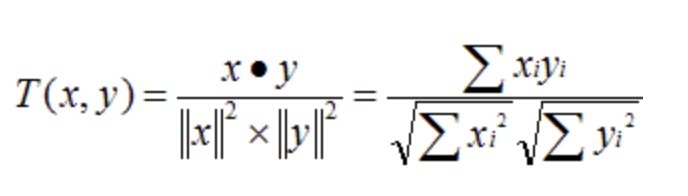


Challenge 1: **Sparsity**

As the result shown, the user-item matrix sparsity is **0.9947083256789352**, which sparse degree is quite high.The same issue also happens on the user-based CF. The sparse dataset makes the calculation heavy and calculates many not suitable correlation. In order to save the calculation time, selection would be performed to eliminate some courses once it exist certain overlap threshold in users' browse bahavior.

Solution: **Precompute Overlapping Courses and set threshold**

A overlapping item-item matrix is set up to see how many users co-rated the course by multiplying Boolean matrix and transposed Boolean matrix. Zero threshold is set. This can help to eliminates courses with zero co-viewed user.

---------


Challenge 2: **Balance Coverage and recommended Accuracy**

After computation, there are around 82.2% items coverage and 92.0% users coverage. However, these results were came out under a lower precomputed threshold (threshold=0) which might decrease the recommended accuracy. That is depended on what value this recommender system applied for, for customer side or provider side. 


Solution: Unlimit the Number of overlap Items threshold  

There is no limit to the number of overlapping items, as long as there is overlap(we set threshold to 0 in the code). It is because the item-item matrix is very sparse. Although there are only one to two recommended similar items, it is better than further lowing the coverage.

-----------

Challenge 3: **ignoration the items that not passed the filtering**

There still exsit some niche courses that didn't received enough rating, so-called long tail item. In item-based filtering, We didn't cover that.


**Limitation**

The biggest limitation is the number of similar items provided are small. Only one to two items can be recommended to the user based on one item. The increase of users and their view towards more elearning courses can resolve this problem.

In [26]:
# Define cosine similarity function
def cosine_sim(df1, df2):
    # check for na in dataframes
    df1na = df1.isna()
    df1clean = df1[~df1na]
    df2clean = df2[~df1na]

    df2na = df2clean.isna()
    df1clean = df1clean[~df2na]
    df2clean = df2clean[~df2na]

    
    # Compute cosine similarity
    distance = cosine(df1clean, df2clean)
    sim = 1 - distance
    
    return sim

In [27]:
def pre_compute(uiMatrix,threshold):

    '''uiMatrix : The original user-item matrix
       threshold: The overlap threshold'''
    
    # to count the presence of co-ratings between courses
    uiMatrixBool = uiMatrix.mask(uiMatrix>0,1)
    uiMatrixBool = uiMatrixBool.fillna(0)
    
    # to find the number of co-ratings(overlapping)
    uiMatrixOverlapping = uiMatrixBool.T.dot(uiMatrixBool)

    # create the item-item similarity matrix
    iiSimMatrix = pd.DataFrame().reindex_like(uiMatrixOverlapping)
    
    # calculate each item's pair similarity, then save the result in the similarity matrix
    coursesToPrecompute = iiSimMatrix.columns

    # extract the item's pair ratings
    for item1 in coursesToPrecompute:
        item1Ratings = uiMatrixNorm[item1]
        for item2 in coursesToPrecompute:
            item2Ratings = uiMatrixNorm[item2]
    
            # set the minimum overlap threshold
            if uiMatrixOverlapping.at[item1,item2] > threshold:
                iiSimMatrix.at[item1, item2] = cosine_sim(item1Ratings, item2Ratings)
                
    # create a list to find the courses that only have the overlap of itself
    coursesList = []

    # drop the course that only have score with itself
    for course in coursesToPrecompute:
        if iiSimMatrix[course].dropna().count() > 1:
            coursesList.append(course)
            
    # make the new iiSimMatrix with the items that passed the filtering 
    iiSimMatrixSelect = iiSimMatrix.loc[coursesList]
    iiSimMatrixSelect = iiSimMatrixSelect.dropna(axis = 1, how = 'all')
    
    return iiSimMatrixSelect

In [28]:
def recommend(currentUser,uiMatrix,similarityMatrix,numItems,preRatingThershold):
   
    '''uiMatrix : The original user-item matrix
       similarityMatrix: The item-item similarity matrix
       numItems: The maximum number of items recommend to user
       preRatingThershold: The threshold of predicted rating'''
    
    '''choose item to find the similar items to reccommend based on the current user's rating'''
    # select the course that can use to recommend for user
    cuRatedItems = uiMatrix.loc[currentUser].dropna().sort_values(ascending=False)
    
    # to find the items user have rated and in the item-item matrix
    cuItemInSelectedList = list(set(cuRatedItems.index).intersection(similarityMatrix.index))
    cuRatedItems = cuRatedItems.loc[cuItemInSelectedList].sort_values(ascending=False)
    
    '''
    find the recommend items and its predicted rating for current user
    see if the user's rated items are in the similarity matrix
    if no, we can't recommend items for user, 
    the system will print 'sorry,no recommend' and terminate the process
    '''
    if len(cuRatedItems) != 0:
        currentItem = cuRatedItems.head(1).index[0]

        # select current item from the similarity matrix, remove not rated items, sort the values and select the top-k items
        recommendationList = similarityMatrix[currentItem].dropna().sort_values(ascending=False)
    
        # drop the items from recommendation list that have rated by user
        ratedItem = list(set(cuRatedItems.index).intersection(recommendationList.index))
        recommendationList.drop(labels=ratedItem, inplace=True)
    
        # only keep the items that have positive score
        recommendationList = recommendationList.where(recommendationList > 0)
        recommendationList = recommendationList.dropna()
        recommendationList = recommendationList.head(numItems)
    
        if recommendationList.empty == False:
            recommend = recommendationList.index.to_list()
        
            # predict the ratings
            itemsToCompare = uiMatrixNorm[recommend]
            predictedRatings = itemsToCompare.mean(axis=0)
            predictedRatings.sort_values(ascending=False, inplace=True)
            cuAvgRating = uiMatrixNorm.loc[[currentUser]].dropna(axis=1).mean(axis=1)
            predictedRatings += cuAvgRating.iloc[0]
            # only recommend the items that its predict rating higher than the threshold
            predictedRatings = predictedRatings[predictedRatings >= preRatingThershold]
        
            return predictedRatings
    
        else:
            return ('Sorry. No recommend.') 
    else:
        return('Sorry. No recommend.')

In [29]:
threshold = 0

In [30]:
iiSimMatrix = pre_compute(uiMatrixNorm,threshold)

In [31]:
iiSimMatrix

,85,59,3,362,100,241,392,337,380,30,...,378,131,342,16,21,278,317,367,5,231
85,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


In [32]:
currentUser = 235
preRatingThershold = 1

In [33]:
recommend(currentUser,uiMatrixNorm,iiSimMatrix,5,preRatingThershold)

26     2.321316
190    1.939753
199    1.386469
69     1.046165
dtype: float64

## 5. Evaluation

### 5.1 Evaluation - User-based CF

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
uiMatrixTh =  to_uiMatrixTh(uiMatrixNorm)                 # New User-Item Matrix with the users who over the overlap threshold
uiMatrixTh = uiMatrixTh.astype(float)
    
uiMatrixThIndex = list(uiMatrixTh.index)                  # Users with overlapping records

In [36]:
def user_course_prediction_toEva(df, userToPredict, numUsers, numItems):
    '''
    The return value is modified for Evaluation
    Returns recommended items that do not include ratings
    Delete all descriptive text output

    '''
    if float(userToPredict)in uiMatrixThIndex:              # Check if the current user has overlap record to recommend courses
        
        cuDf = uiMatrixTh.loc[userToPredict]                # Get the record of current user 
    
        corrDf = uiMatrixTh.corrwith(cuDf, axis=1, method='pearson')    # Pearson correlation between current user to every overlap user
    
        corrDf.sort_values(ascending=False, inplace=True)   
        corrDf.drop(labels=[userToPredict], inplace=True)   # Remove the current user
        corrDf = corrDf.dropna()
        corrDf = corrDf.where(corrDf > 0)                   # Remove courses with Pearson correlation =  -1
        corrDf = corrDf.head(numUsers)                      # Top K most similar users 
    
    
        # Predict courses ratings
        toPredict = cuDf[cuDf.isna()]                       # Courses that the current user has not interacted with
        ratings = uiMatrixTh.loc[corrDf.index]              # Get the ratings of the similar users
        ratingsToPredict = ratings[toPredict.index]
        predictedRatings = ratingsToPredict.mean()          # Predictive rating
        predictedRatings.sort_values(ascending=False, inplace=True)
        predictedRatings = predictedRatings.dropna()        # Remove the items without predict rating
        predictList = list(predictedRatings.head(numItems).keys())     # Top K items 
    
    
        # Returns recommended items that do not include ratings
        return predictList

In [37]:
# Test
user_course_prediction_toEva(uiMatrixNorm, 151, 5, 5)

[44, 118, 328, 375]

In [38]:
recItem_ub = []
recUser_ub = []
allItem_ub = []

In [39]:
def evaluation_coverage_ub(df):
    '''
    To calculate user coverage and catalogue coverage for user-based CF

    '''
    for user in df.index:
        recommendItem = user_course_prediction_toEva(df, user, 5, 5)
        if (type(recommendItem).__name__=='list'):      
            recUser_ub.append(user)                  # Add users who have been successfully recommended to the list
            for item in recommendItem:
                allItem_ub.append(item)              # Add recommended items
                if item not in recItem_ub:
                    recItem_ub.append(item)          # Unique recommended items
        else:
            continue

    user = len(uiMatrixNorm.index)               # Number of all users
    catalogue = len(uiMatrixNorm.columns)        # Number of all items
    userInRec = len(recUser_ub)                     # Number of users who have been recommended
    itemInRec = len(recItem_ub)                     # Number of items in recommend lists

    user_coverage = float(userInRec/ user)
    catalogue_coverage = float(itemInRec/ catalogue)

    print("The user coverage: ",user_coverage)
    print("The catalogue coverage: ",catalogue_coverage)

In [40]:
# The coverage for user-based CF
evaluation_coverage_ub(uiMatrixNorm)            

The user coverage:  0.03164029975020816
The catalogue coverage:  0.11461318051575932


In [41]:
# The item with its recommended frequence
dict = {}
for key in allItem_ub:
    dict[key] = dict.get(key, 0) + 1

lst2 = list(dict.values())

In [42]:
# The frequence and the number of courses
dict2 = {}
for key in lst2:
    dict2[key] = dict2.get(key, 0) + 1
print(dict2)

{1: 32, 2: 5, 4: 2, 3: 1}


Text(0, 0.5, 'number of courses')

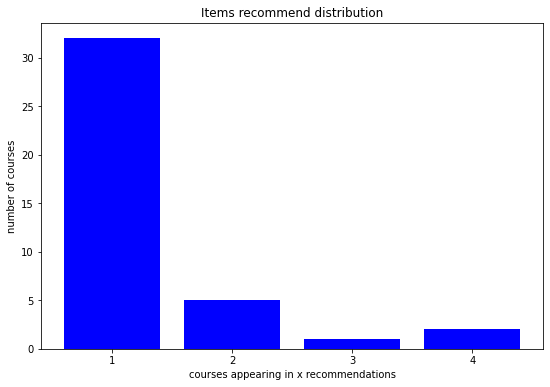

In [43]:
# Visulization
plt.figure(figsize=(9,6))
plt.bar(dict2.keys(), dict2.values(), color='b')
plt.title('Items recommend distribution',fontsize='large') 
plt.xlabel('courses appearing in x recommendations')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('number of courses')

### 5.2 Evaluation - Item-based CF

In [44]:
# create three lists to save the recommend items and users
recItem_ib = []
recUser_ib = []
allItem_ib = []

In [45]:
for user in uiMatrixNorm.index:
    recommendations = recommend(user,uiMatrixNorm,iiSimMatrix,5,preRatingThershold)
    if (type(recommendations).__name__=='Series'):
        recItem_ib = list(set(recItem_ib).union(set(recommendations.index)))
        recUser_ib.append(user)
        Items = recommendations.index.tolist()
        allItem_ib = allItem_ib + Items

In [46]:
# compute coverage ratings
user = len(uiMatrixNorm) # the number of users
catalogue = len(uiMatrixNorm.columns) # the number of items
userInRec = len(recUser_ib) # the number of users who have recommend items
itemInRec = len(recItem_ib) # the number of items which have been recommended
user_coverage = float(userInRec/ user)
catalogue_coverage = float(itemInRec/ catalogue)

In [47]:
user_coverage

0.9208992506244796

In [48]:
catalogue_coverage

0.8223495702005731

In [49]:
# Find the item with its recommended frequence
dict = {}
for key in allItem_ib:
    dict[key] = dict.get(key, 0) + 1

lst2 = list(dict.values())

In [50]:
# Find the frequence and the number of courses
dict2 = {}
for key in lst2:
    dict2[key] = dict2.get(key, 0) + 1
print(dict2)

{27: 4, 2: 14, 24: 7, 18: 8, 1: 10, 34: 5, 8: 18, 12: 8, 22: 5, 29: 4, 41: 1, 37: 1, 38: 1, 15: 11, 31: 4, 14: 12, 57: 1, 25: 11, 4: 23, 16: 6, 50: 1, 9: 15, 23: 8, 45: 1, 43: 2, 11: 9, 5: 14, 20: 2, 7: 11, 3: 11, 36: 1, 26: 5, 13: 7, 17: 10, 6: 7, 28: 3, 10: 13, 39: 2, 48: 1, 33: 1, 42: 1, 35: 1, 32: 1, 21: 3, 30: 2, 19: 1}


Text(0.5, 1.0, 'Items recommend distribution')

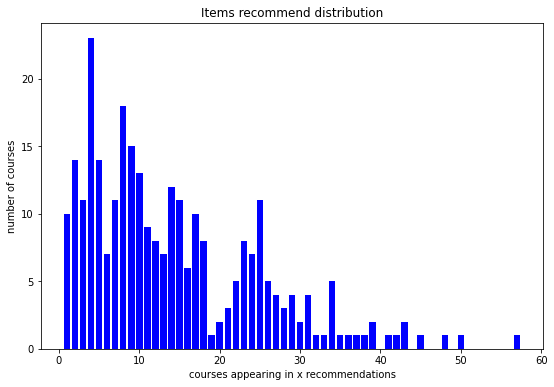

In [51]:
# Draw a chart to visulization
plt.figure(figsize=(9,6))
plt.bar(dict2.keys(), dict2.values(),color='b')
plt.xlabel('courses appearing in x recommendations')
plt.ylabel('number of courses')
plt.title('Items recommend distribution')

## 6. Tuning

### 6.1 Tuning - User-based CF

- To develop a more accurate and personalized recommendation system, we set the ```coInterThreshold``` to 2 to avoid 1 or -1 similarity among too few co-interested users. That is, We only select users whose overlap value is greater than 2 to calculate the pearson similarity. 

- However, because of the sparse matrix, we cannot print the recommendation results(i.e., there are no two users in our matrix with overlapping values greater than 2). But in real world problems, our tuning can make sense.

In [52]:
def to_uiMatrixTh_tune(uiMatrix):
    ''' 
    Eliminate the users with less overlapping courses to other users '''
    
    uiMatrixBool = uiMatrix.applymap(lambda x: to_bool(x))
    overlappingCourse = uiMatrixBool.dot(uiMatrixBool.T)       # The user-user overlapping
    usersList = overlappingCourse.columns
    
    overlapUser = []
    for user in usersList:                                    # Loop to access every user
        lookUser = overlappingCourse.loc[user]
        lookUser.to_frame()
    
        '''
        We take lists of users whose overlap value is greater than 1
        Because the dataframe contains the 'self'-course, the counting should be greater than 1
        '''
        coInterThreshold = 2
        if lookUser[lookUser > coInterThreshold].count() > 1:
            overlapUser.append(user)
            
    uiMatrixTh_tune = uiMatrix.loc[overlapUser]
    uiMatrixTh_tune = uiMatrixTh_tune.dropna(axis = 'columns', how = 'all')

    return uiMatrixTh_tune

In [53]:
def user_course_prediction_tune(df, userToPredict, numUsers, numItems):
    '''
    Build the overlapping matrix to recommend courses for users who over the overlap threshold
    df : The original user-item matrix
    userToPredict : The current user
    numUsers : Number of similar users
    numItems : Number of recommended courses
    '''
    uiMatrixTh =  to_uiMatrixTh_tune(df)                         # New User-Item Matrix with the users who over the overlap threshold
    uiMatrixTh = uiMatrixTh.astype(float)
    
    uiMatrixThIndex = list(uiMatrixTh.index)                 # Users with overlapping records
    if float(userToPredict) not in uiMatrixThIndex:         # Check if the current user has overlap record to recommend courses
        print('No recommendation for the user ' + str(userToPredict) )
        
    else:
        cuDf = uiMatrixTh.loc[userToPredict]                # Get the record of current user 
    
        corrDf = uiMatrixTh.corrwith(cuDf, axis=1, method='pearson')    # Pearson correlation between current user to every overlap user
    
        corrDf.sort_values(ascending=False, inplace=True)   
        corrDf.drop(labels=[userToPredict], inplace=True)   # Remove the current user
        corrDf = corrDf.dropna()
        corrDf = corrDf.where(corrDf > 0)                   # Remove courses with Pearson correlation =  -1
        corrDf = corrDf.head(numUsers)                      # Top K most similar users 
    
    
        # Predict courses ratings
        toPredict = cuDf[cuDf.isna()]                       # Courses that the current user has not interacted with
        ratings = uiMatrixTh.loc[corrDf.index]              # Get the ratings of the similar users
        ratingsToPredict = ratings[toPredict.index]
        predictedRatings = ratingsToPredict.mean()          # Predictive rating
        predictedRatings.sort_values(ascending=False, inplace=True)
        predictedRatings = predictedRatings.dropna()        # Remove the items without predict rating
        predictList = predictedRatings.head(numItems)       # Top K items with high predicted ratings
    
    
        # Result
        if len(predictList) == 0:
            print('No recommendation for the user ' + str(userToPredict) )
        else:
            print('For the user ' + str(userToPredict) + ', the Top ' + str(len(predictList)) + ' recommended item(s) and the prediction rating:')
        return predictList


In [54]:
user_course_prediction_tune(uiMatrixNorm, 1029, 5, 5)

No recommendation for the user 1029


### 6.2 Tuning - Item-based CF

- For item-based recommendation algorithm, according to cosine similarity calculation formula, when there is only 1 overlap, the similarity calculated is always 1. So we set the  ```threshold``` of overlap to 1, we only select items with overlap greater than 1.  This makes the calculation of similarity between items more accurate, thus providing users with more accurate recommendations.

- At the same time, adjust the ``` preRatingThershold``` . Use average rating of current user as the minimum threshold of predict rating of recommend course for user. This ensures that the predicted rating of recommended courses are above average and avoids recommending courses that users do not like.

- After tuning parameters, the item-Base recommender system can recommend courses to users more accurately. However, because the user-items matrix is too sparse, the number of recommended courses will decrease after the ```threshold``` is raised, and the coverage of the recommender system will also decrease a little.

In [55]:
# the tune item-item similarity matrix
iiSimMatrix_Tune = pre_compute(uiMatrixNorm,threshold = 1)

In [56]:
iiSimMatrix_Tune

,3,160,240,194,171,255,155,291,82,152,193
3,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.934088
160,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.765729,NaN,NaN,NaN
240,NaN,NaN,1.000000,NaN,NaN,0.861708,NaN,NaN,NaN,NaN,NaN
194,NaN,NaN,NaN,1.00000,0.905420,NaN,NaN,NaN,NaN,NaN,NaN
171,NaN,NaN,NaN,0.90542,1.000000,NaN,NaN,NaN,0.525655,NaN,NaN
255,NaN,NaN,0.861708,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
155,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.862581,NaN
291,NaN,0.765729,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
82,NaN,NaN,NaN,NaN,0.525655,NaN,NaN,NaN,1.000000,NaN,NaN
152,NaN,NaN,NaN,NaN,NaN,NaN,0.862581,NaN,NaN,1.000000,NaN


In [57]:
# choose user 921 as the current user
currentUser = 921
# use average rating of current user as the minimum threshold of predict rating of recommend course for user
preRatingThershold_Tune = uiMatrixNorm.iloc[921].mean()

In [58]:
# recommend after tuning
recommend(currentUser ,uiMatrixNorm,iiSimMatrix_Tune,5,preRatingThershold_Tune)

82    6.074322
dtype: float64